# p.162【章末問題】混合正規分布

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import dirichlet
from scipy.stats import multivariate_normal as normal

確率モデル  
$\displaystyle p(x\mid w)=\sum_{k=1}^{K}\frac{a_k}{(2\pi\sigma^2)^{N/2}}\exp\left(-\frac{\|x-m_k\|}{2\sigma^2}\right)$  
のベイズ推定を2通りの方法でやってみる.  
事前分布は$a$についてディリクレ分布,$~m$について正規分布を用いる.  
$\displaystyle\varphi(a\mid \phi)=\frac{1}{Z(\phi)}\prod_{k=1}^{K}(a_k)^{\phi_k-1}$  
$\displaystyle\varphi(m_k\mid\mu_k,\lambda_k)=\left(\frac{\lambda_k}{2\pi}\right)^{N/2}\exp\left(-\frac{\lambda_k}{2}\|m_k-\mu_k\|\right)~~~~(k=1,\dots,K)$  

In [2]:
def model(x,a,m,sigma=1.0):
    a=a/a.sum()
    K=len(a)
    p=0
    for k in range(K):
        p+=a[k]*normal(m[k],sigma).pdf(x)
    return p

以下の関数でパラメータ$w=(a,m)$を与えたときのサンプルを$n$個生成する.

In [15]:
def generate(a,m,sigma=1.0,n=100):
    # K:コンポーネント数
    # N:データの次元
    K,N=m.shape
    X=np.zeros((n,N))
    for i in range(n):
        k=np.random.choice(range(K),p=a)
        x=normal(m[k],sigma).rvs()
        X[i]=x
    return X

以下で述べる2つの方法では, 潜在変数を導入して考える.  
潜在変数$y$を含めた確率モデルは  
$\displaystyle p(x,y\mid w)=\prod_{k=1}^K\left(\frac{a_k}{(2\pi\sigma^2)^{N/2}}\exp\left(-\frac{\|x-m_k\|}{2\sigma^2}\right)\right)^{y_k}$  
と表せる.  
この場合は$a,b$の事前分布が共役事前分布になっているので, もし潜在変数も観測データとして与えられたら, 事後分布はハイパーパラメータの更新のみで導くことができる.  
$\{(X_i,Y_i)\}_{i=1}^n$が与えられたときのハイパーパラメータの更新は以下のようになる  
$\displaystyle\phi_{k}\leftarrow\phi_{k}+\sum_{i=1}^{n}Y_{ik}$  
$\displaystyle\mu_{k}\leftarrow\frac{\lambda_{k}\mu_{k}+\displaystyle\sum_{i=1}^{n}Y_{ik}X_{i}}{\lambda_{k}+\displaystyle\sum_{i=1}^{n}Y_{ik}}$  
$\displaystyle\lambda_{k}\leftarrow\lambda_{k}+\sum_{i=1}^{n}Y_{ik}$

# 1. ギブスサンプリング

ギブスサンプリングでは, 潜在変数$(Y_1,\cdots,Y_n)$のサンプリングとパラメータ$(a,m)$のサンプリングを交互に行う  

In [39]:
def hyper_update(phi,mu,lam,X,Y):
    n,N=X.shape
    n,K=Y.shape
    phi_=phi+Y.sum(axis=0)
    mu_=np.zeros((K,N))
    for k in range(K):
        XYk=np.zeros(N)
        for i in range(n):
            XYk+=Y[i][k]*X[i]
        mu_[k]=(lam[k]*mu[k]+XYk)/(lam[k]+Y.sum(axis=0)[k])
    lam_=lam+Y.sum(axis=0)
    return phi_,mu_,lam_

サンプル$(X_1,\cdots,X_n)$とパラメータ$(a,m)$が与えられたとき, $Y_{ik}=1$となる確率は  
$\displaystyle\frac{a_k\exp\left(-\displaystyle\frac{\|X_i-m_k\|}{2\sigma^2}\right)}{\displaystyle\sum_{k=1}^{K}a_k\exp\left(-\frac{\|X_i-m_k\|}{2\sigma^2}\right)}$

In [41]:
def latent_sampling(a,b,X,sigma=1.0):
    n,N=X.shape
    K=len(a)
    Y=np.zeros((n,K))
    for i in range(n):
        pY=np.array([a[k]*normal(m[k],sigma).pdf(X[i]) for k in range(K)])
        pY=pY/sum(pY)
        Yi=np.zeros(K)
        k=np.random.choice(range(K),p=pY)
        Yi[k]=1
        Y[i]=Yi
    return Y

事後分布からパラメータをサンプリングする関数

In [63]:
def gibbs_sampling(X,K,sigma=1.0,times=100,burn=20):
    X=np.array(X)
    # n:データ数
    # N:データの次元
    n,N=X.shape
    a_list=np.zeros((times,K))
    m_list=np.zeros((times,K,N))
    # ハイパーパラメータの初期値
    phi=np.ones(K)
    mu=np.zeros((K,N))
    lam=np.ones(K)
    for t in range(times):
        # 事後分布からのサンプリング
        a=dirichlet(phi).rvs()[0]
        m=np.array([normal(mu[k],1/lam[k]).rvs() for k in range(K)])
        a_list[t]=a
        m_list[t]=m
        # 潜在変数のサンプリング
        Y=latent_sampling(a,m,X)
        # ハイパーパラメータの更新
        phi,mu,lam=hyper_update(phi,mu,lam,X,Y)
    return a_list,m_list

パラメータのサンプルについて確率モデルを平均することで, 予測分布を得る

In [64]:
def predict(x,a_list,m_list):
    T=len(a_list)
    p=0
    for t in range(T):
        a=a_list[t]
        m=m_list[t]
        p+=model(x,a,m)
    return p/T

### 実験

In [67]:
%%time
a=np.array([0.3,0.3,0.4])
m=np.array([[0,5],[-5,0],[5,0]])
X=generate(a,m,n=100)
a_list,m_list=gibbs_sampling(X,3)

CPU times: user 9.92 s, sys: 130 ms, total: 10 s
Wall time: 17.1 s


CPU times: user 3min 42s, sys: 2.69 s, total: 3min 45s
Wall time: 5min 34s


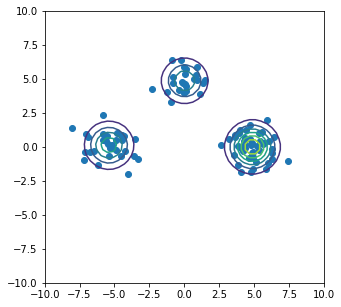

In [68]:
%%time
plt.figure(figsize=(5,5))
plt.xlim(-10,10)
plt.ylim(-10,10)
plt.scatter(X.T[0],X.T[1])
size=50
lin=np.linspace(-10,10,size)
x0,x1=np.meshgrid(lin,lin)
p=[[predict([x0[r][c],x1[r][c]],a_list,m_list) for c in range(size)] for r in range(size)]
plt.contour(x0,x1,p)